In [1]:
!pip install pytorch_msssim

In [2]:
from google.colab import drive
import glob
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import tifffile as tiff

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision                                           # High-level computer vision utilities and pretrained models
from torchvision import transforms, models                   # Transformations for image preprocessing and model zoo
from pytorch_msssim import ssim

from sklearn.decomposition import PCA
from matplotlib.colors import BoundaryNorm
import matplotlib.patches as patches

import umap.umap_ as umap


import cv2
from skimage.registration import phase_cross_correlation
from skimage.io import imsave
from scipy.ndimage import fourier_shift
import copy

from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # For more reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Seed set to {seed}")

## Complete Data

In [4]:
#SETUP AND PATHS
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully.")

# Define the base paths
BASE_PATH = '/content/drive/MyDrive/DS_ML_MFFF/zfish'

FIG_DIR = Path(BASE_PATH) / "figures"
FIG_DIR.mkdir(exist_ok=True)
print("Figures will be saved in:", FIG_DIR)

# Define all image and mask directories
TRAIN_MASK_IMG_DIR = Path(BASE_PATH) / 'train' / 'masked_images'
TEST_MASK_IMG_DIR = Path(BASE_PATH) / 'test' / 'masked_images'
print(f"\nTraining Images Path: {TRAIN_MASK_IMG_DIR}")
print(f"\nTraining Images Path: {TEST_MASK_IMG_DIR}")

if TRAIN_MASK_IMG_DIR.is_dir(): # Updated check for Path object
    print("Path exists and is ready.")
else:
    print("!!! ERROR: Path not found. Please check your folder structure on Drive.")

if TEST_MASK_IMG_DIR.is_dir(): # Updated check for Path object
    print("Path exists and is ready.")
else:
    print("!!! ERROR: Path not found. Please check your folder structure on Drive.")

files_train = sorted(list(TRAIN_MASK_IMG_DIR.glob("*.tif")))
files_test = sorted(list(TEST_MASK_IMG_DIR.glob("*.tif")))

# The first 10 files (embryos) for training.
# Adjust the slice [0:10] if you want a different specific set of files.
#files_train = all_train_files[0:10]
#files_test = all_test_files[0:10] # Subset the test files as well

#print(f"Total original training files: {len(all_train_files)}")
print(f"Using {len(files_train)} training files for the analysis.")

#print(f"Total original test files: {len(all_test_files)}")
print(f"Using {len(files_test)} test files for the analysis.")

Mounting Google Drive...
Mounted at /content/drive
Drive mounted successfully.
Figures will be saved in: /content/drive/MyDrive/DS_ML_MFFF/zfish/figures

Training Images Path: /content/drive/MyDrive/DS_ML_MFFF/zfish/train/masked_images

Training Images Path: /content/drive/MyDrive/DS_ML_MFFF/zfish/test/masked_images
Path exists and is ready.
Path exists and is ready.
Using 39 training files for the analysis.
Using 12 test files for the analysis.


In [5]:
# Load Stacks

stacks_train = []
embryo_ids_train = []
lengths_train = []

print("\nLoading stacks...")
for p in files_train:
    arr_train = tiff.imread(str(p)).astype(np.float32) # shape: (T_i, H, W)

    stacks_train.append(arr_train)
    embryo_ids_train.append(p.stem)
    lengths_train.append(arr_train.shape[0])

total_frames_train= sum(lengths_train)
print("Total frames across all stacks:", total_frames_train)

# Metadata per frame (embryo_id, frame index)
frame_embryo_train = np.concatenate([[eid] * L for eid, L in zip(embryo_ids_train, lengths_train)])
frame_idx_train = np.concatenate([np.arange(L) for L in lengths_train])

dfmeta_train = pd.DataFrame({
    "embryo_id": frame_embryo_train,
    "frame_idx": frame_idx_train
})
print("\nMetadata DataFrame Head and Shape:")
print(dfmeta_train.head())
print(dfmeta_train.shape)


Loading stacks...
Total frames across all stacks: 17550

Metadata DataFrame Head and Shape:
                   embryo_id  frame_idx
0  masked_Acq_Bmp_tra_E1005o          0
1  masked_Acq_Bmp_tra_E1005o          1
2  masked_Acq_Bmp_tra_E1005o          2
3  masked_Acq_Bmp_tra_E1005o          3
4  masked_Acq_Bmp_tra_E1005o          4
(17550, 2)


In [6]:
# Load Stacks for test

stacks_test = []
embryo_ids_test= []
lengths_test = []

print("\nLoading stacks...")
for p in files_test:
    arr_test = tiff.imread(str(p)).astype(np.float32) # shape: (T_i, H, W)

    stacks_test.append(arr_test)
    embryo_ids_test.append(p.stem)
    lengths_test.append(arr_test.shape[0])

total_frames_test= sum(lengths_test)
print("Total frames across all stacks:", total_frames_test)

# Metadata per frame (embryo_id, frame index)
frame_embryo_test = np.concatenate([[eid] * L for eid, L in zip(embryo_ids_test, lengths_test)])
frame_idx_test = np.concatenate([np.arange(L) for L in lengths_test])

dfmeta_test= pd.DataFrame({
    "embryo_id": frame_embryo_test,
    "frame_idx": frame_idx_test
})
print("\nMetadata DataFrame Head and Shape:")
print(dfmeta_test.head())
print(dfmeta_test.shape)


Loading stacks...
Total frames across all stacks: 5400

Metadata DataFrame Head and Shape:
                   embryo_id  frame_idx
0  masked_Acq_Bmp_tes_E1005o          0
1  masked_Acq_Bmp_tes_E1005o          1
2  masked_Acq_Bmp_tes_E1005o          2
3  masked_Acq_Bmp_tes_E1005o          3
4  masked_Acq_Bmp_tes_E1005o          4
(5400, 2)


In [7]:
class AEDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform
        self.index = []

        print("Pre-calculating frame indices (reading file metadata)...")

        for stack_idx, path in enumerate(self.file_paths):
            try:

                with tiff.TiffFile(str(path)) as tif:
                    # 2. Get the number of frames/pages in the current TIFF file
                    T = len(tif.pages)

                # Build the index list (stack_idx, frame_idx)
                for t in range(T):
                    self.index.append((stack_idx, t))
            except Exception as e:
                # The FileNotFoundError occurs here if the file path is bad
                print(f"!!! CRITICAL ERROR: {path}")
                print(f"!!! Python Error: {e}")

        # Initialize cache
        self._stack_cache = {}
        self._max_cache_size = 5
    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        # 1. Get the path and frame index
        stack_idx, t = self.index[idx]
        file_path = self.file_paths[stack_idx]

        if stack_idx not in self._stack_cache:

            current_stack = tiff.imread(str(file_path)).astype(np.float32)

            # Update cache
            self._stack_cache[stack_idx] = current_stack
            if len(self._stack_cache) > self._max_cache_size:
                # Remove the oldest stack
                oldest_key = next(iter(self._stack_cache))
                del self._stack_cache[oldest_key]
        else:
            current_stack = self._stack_cache[stack_idx]

        # 4. Extract the single frame
        img = current_stack[t] # (H, W)

        # 5. Apply your normalization (as you had it)
        img -= img.min()
        if img.max() > 0:
            img = img / img.max()

        # Add channel dimension -> (1, H, W)
        if img.ndim == 2:
            img = img[None, :, :] # (1, H, W)

        image = torch.from_numpy(img)

        # Apply transform
        if self.transform:
            image = self.transform(image)

        return image.float(), image.float()

In [8]:
set_seed(42)

Seed set to 42


In [9]:
# Data augmentation + preprocessing for training

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),              # Random horizontal flip: Increases symmetry: retinas are often symmetric
    transforms.RandomRotation(degrees=180),               # Random rotation: Simulates head tilt, camera rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  #Color Jitter simulates variation across devices
    #transforms.RandomAffine(degrees=10, translate=(0.05,0.005)),
    # No ToTensor here: AEDataset already returns a torch tensor
])

# For val/test we do not need augmentation
val_transform = None
test_transform = None

In [10]:
#Base dataset (no transform) to define indices
base_dataset = AEDataset(file_paths=files_train, transform=None)
num_frames = len(base_dataset)
print("Total frames in base dataset:", num_frames)

Pre-calculating frame indices (reading file metadata)...
Total frames in base dataset: 17550


In [11]:
#Train/Val split indices (80/20 split)
train_size = int(0.8 * num_frames)
val_size = num_frames - train_size

indices = torch.randperm(num_frames).tolist()
train_indices = indices[:train_size]
val_indices   = indices[train_size:]


# Datasets with and without transform
# Train dataset with augmentation
train_dataset = AEDataset(file_paths=files_train, transform=train_transform)

# Validation dataset without augmentation
val_dataset   = AEDataset(file_paths=files_train, transform=val_transform)

# Subsets using the same indices
train_ds1 = Subset(train_dataset, train_indices)
val_ds1   = Subset(val_dataset,   val_indices)

batch_size = 16

train_loader = DataLoader(train_ds1, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds1, batch_size=batch_size, shuffle=False)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))


#Test dataset and loader (no augmentation)
test_dataset = AEDataset(file_paths=files_test, transform=test_transform)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Test dataset length (frames):", len(test_dataset))
print("Train batches:", len(test_loader))

Pre-calculating frame indices (reading file metadata)...
Pre-calculating frame indices (reading file metadata)...
Train batches: 878 Val batches: 220
Pre-calculating frame indices (reading file metadata)...
Test dataset length (frames): 5400
Train batches: 338


In [12]:
class AutoEncoder_nosup(nn.Module):
    def __init__(self, latent_dim=128, input_size=128):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        # compute encoder output shape
        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_size, input_size)
            h = self.encoder(dummy)
        self.enc_out_shape = h.shape[1:]           # (C, H, W)
        enc_out_dim = h.numel()                    # C * H * W

        self.flatten = nn.Flatten()
        self.fc_latent = nn.Linear(enc_out_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, enc_out_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = self.flatten(h)
        z = self.fc_latent(h)
        return z

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, *self.enc_out_shape)
        x_hat = self.decoder(h)
        return x_hat

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128

model1 = AutoEncoder_nosup(latent_dim=latent_dim).to(device)

optimizer = torch.optim.Adam(model1.parameters(), lr=1e-5)

#Loss Functions
criterion_mse = nn.MSELoss()

def ssim_loss(x,y):
    return 1-ssim(x,y,data_range=1.0)

def combined_loss(x_hat, x, alpha=0.1):
    mse=criterion_mse(x_hat, x)
    ssim_1=ssim_loss(x_hat, x)
    return alpha * mse + (1-alpha) * ssim_1


In [14]:
latent_dim = 128
model_loaded = AutoEncoder_nosup(latent_dim=latent_dim).to(device)

In [15]:
best_model_path = "/content/drive/MyDrive/DS_ML_MFFF/zfish/best_ae_zfish.pth"

state_dict = torch.load(best_model_path, map_location=device)
model_loaded.load_state_dict(state_dict)
model_loaded.eval()

print("Model successfully loaded!")

Model successfully loaded!


In [16]:
save_path = "/content/drive/MyDrive/DS_ML_MFFF/zfish"
os.makedirs(save_path, exist_ok=True)

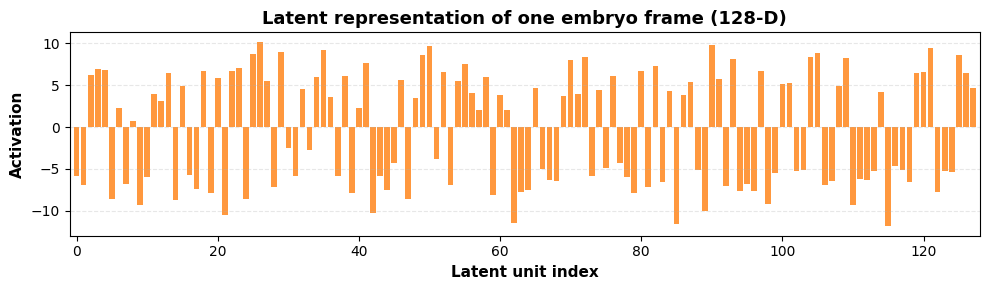

Saved: /content/drive/MyDrive/DS_ML_MFFF/zfish/latent_dimension_bar.svg


In [17]:
# Latent Dimension Illustration

# Make sure model is in eval mode and using best weights
model_loaded.load_state_dict(torch.load(best_model_path, map_location=device))
model_loaded.eval()

# Take one sample from test_dataset
single_img, _ = test_dataset[0]     # (1, H, W) tensor
single_img = single_img.unsqueeze(0).to(device)  # (1,1,H,W)

with torch.no_grad():
    z_example = model_loaded.encode(single_img)  # (1, latent_dim)

z_example = z_example.squeeze(0).cpu().numpy()

figB2, axB = plt.subplots(figsize=(10, 3))

# Using a clean color
axB.bar(np.arange(latent_dim), z_example, width=0.8, color="#ff7f0e", alpha=0.8)

axB.set_xlabel("Latent unit index", fontsize=11, fontweight='bold')
axB.set_ylabel("Activation", fontsize=11, fontweight='bold')
axB.set_title(f"Latent representation of one embryo frame ({latent_dim}-D)", fontsize=13, fontweight="bold")
axB.set_xlim(-1, latent_dim)
axB.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()

out_path_latent = os.path.join(save_path, "latent_dimension_bar.svg")
plt.savefig(out_path_latent, format='svg', bbox_inches="tight")

plt.show()

print(f"Saved: {out_path_latent}")

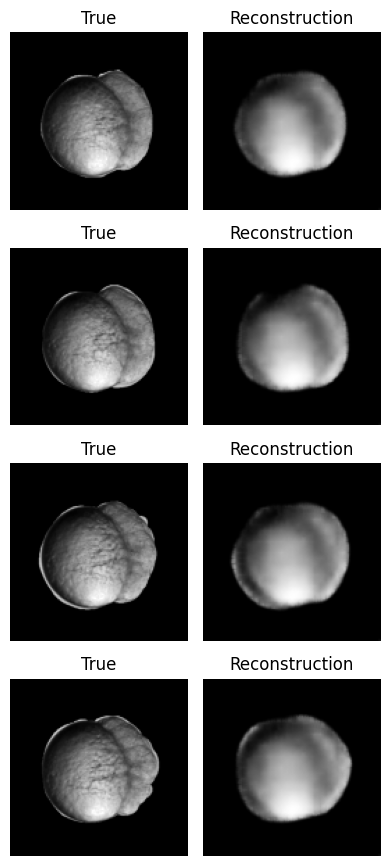

In [18]:
# model_loaded already defined and in eval mode
batch, _ = next(iter(test_loader))   # shape (B,1,128,128)
batch = batch.to(device)

with torch.no_grad():
    recon = model_loaded(batch)

batch_np = batch.cpu().numpy()
recon_np = recon.cpu().numpy()

n_show = 4  # number of examples

fig, axes = plt.subplots(n_show, 2, figsize=(4, n_show * 2.2))

for i in range(n_show):
    # TRUE
    axes[i, 0].imshow(batch_np[i, 0], cmap="gray")
    axes[i, 0].set_title("True")
    axes[i, 0].axis("off")

    # RECON
    axes[i, 1].imshow(recon_np[i, 0], cmap="gray")
    axes[i, 1].set_title("Reconstruction")
    axes[i, 1].axis("off")

plt.tight_layout()

filename = "reconstruction_check.svg"
out_path_svg = os.path.join(save_path, filename)
plt.savefig(out_path_svg, format='svg', bbox_inches='tight')


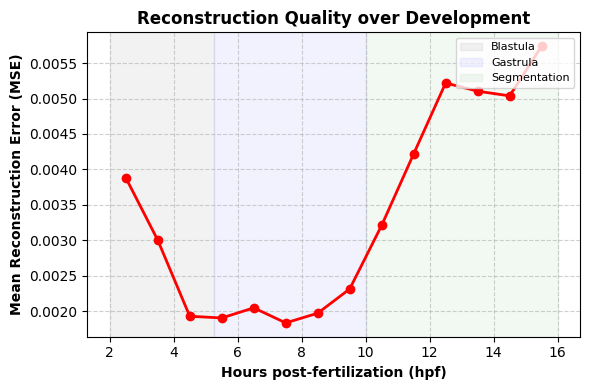

Saved: /content/drive/MyDrive/DS_ML_MFFF/zfish/error_vs_hpf.svg


In [19]:
# Compute per-frame reconstruction error
all_errors = []
model_loaded.eval()

with torch.no_grad():
    for batch, _ in test_loader:
        batch = batch.to(device)
        recon = model_loaded(batch)
        mse = ((batch - recon)**2).view(batch.size(0), -1).mean(dim=1)
        all_errors.append(mse.cpu().numpy())

all_errors = np.concatenate(all_errors)

# Build hpf_values (2–16 hpf, linear per embryo)
hpf_start = 2.0
hpf_end   = 16.0

hpf_values = []
for L in lengths_test:
    if L <= 1:
        times = np.array([(hpf_start + hpf_end)/2])
    else:
        times = np.linspace(hpf_start, hpf_end, L)
    hpf_values.append(times)

hpf_values = np.concatenate(hpf_values)

# Bin and plot
bins = np.arange(2.0, 17.0, 1.0)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
digitized = np.digitize(hpf_values, bins)

mean_errors = []
for i in range(1, len(bins)):
    mask = digitized == i
    if np.any(mask):
        mean_errors.append(all_errors[mask].mean())
    else:
        mean_errors.append(np.nan)

mean_errors = np.array(mean_errors)

fig2, ax = plt.subplots(figsize=(6, 4))

# Add developmental stage backgrounds
ax.axvspan(2, 5.25, color='gray', alpha=0.1, label='Blastula')
ax.axvspan(5.25, 10, color='blue', alpha=0.05, label='Gastrula')
ax.axvspan(10, 16, color='green', alpha=0.05, label='Segmentation')

# Plot the error
ax.plot(bin_centers, mean_errors, marker="o", color='red', linewidth=2, markersize=6)

ax.set_xlabel("Hours post-fertilization (hpf)", fontweight='bold')
ax.set_ylabel("Mean Reconstruction Error (MSE)", fontweight='bold')
ax.set_title("Reconstruction Quality over Development", fontsize=12, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()

out_path_svg_err = os.path.join(save_path, "error_vs_hpf.svg")
plt.savefig(out_path_svg_err, format='svg', bbox_inches="tight")

plt.show()
print(f"Saved: {out_path_svg_err}")

In [21]:
def extract_latent_ae(model1, dataset, device):
    model1.eval()
    latents = []

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    with torch.no_grad():
        for noisy, clean in loader:
            noisy = noisy.to(device)
            z = model1.encode(noisy)
            latents.append(z.cpu())

    Z = torch.cat(latents, dim=0)
    return Z

In [22]:
# Clean dataset
eval_dataset_train = AEDataset(file_paths=files_train, transform=None)
eval_dataset_test = AEDataset(file_paths=files_test, transform=None)
# Extract latent codes for all test frames
Z_test = extract_latent_ae(model_loaded, eval_dataset_test, device)  # tensor (N_test, latent_dim)
Z_test_np = Z_test.numpy()

print("Latent shape (test):", Z_test_np.shape)

# PCA to 2D
pca = PCA(n_components=2)
Z_test_pca = pca.fit_transform(Z_test_np)  # (N_test, 2)
print("PCA shape:", Z_test_pca.shape)

Pre-calculating frame indices (reading file metadata)...
Pre-calculating frame indices (reading file metadata)...
Latent shape (test): (5400, 128)
PCA shape: (5400, 2)


In [23]:
embryo_ids_test = dfmeta_test["embryo_id"].values
print("Example embryo IDs:", embryo_ids_test[:5])

conditions = []

for eid in embryo_ids_test:
    eid_low = eid.lower()

    if "_bmp_" in eid_low:
        conditions.append("BMP")
    elif "_nod_" in eid_low:
        conditions.append("Nodal")
    elif "_nor_" in eid_low:
        conditions.append("WT")
    else:
        conditions.append("Unknown")

conditions = np.array(conditions)
print("Unique conditions:", np.unique(conditions, return_counts=True))


Example embryo IDs: ['masked_Acq_Bmp_tes_E1005o' 'masked_Acq_Bmp_tes_E1005o'
 'masked_Acq_Bmp_tes_E1005o' 'masked_Acq_Bmp_tes_E1005o'
 'masked_Acq_Bmp_tes_E1005o']
Unique conditions: (array(['BMP', 'Nodal', 'WT'], dtype='<U5'), array([1800, 1800, 1800]))


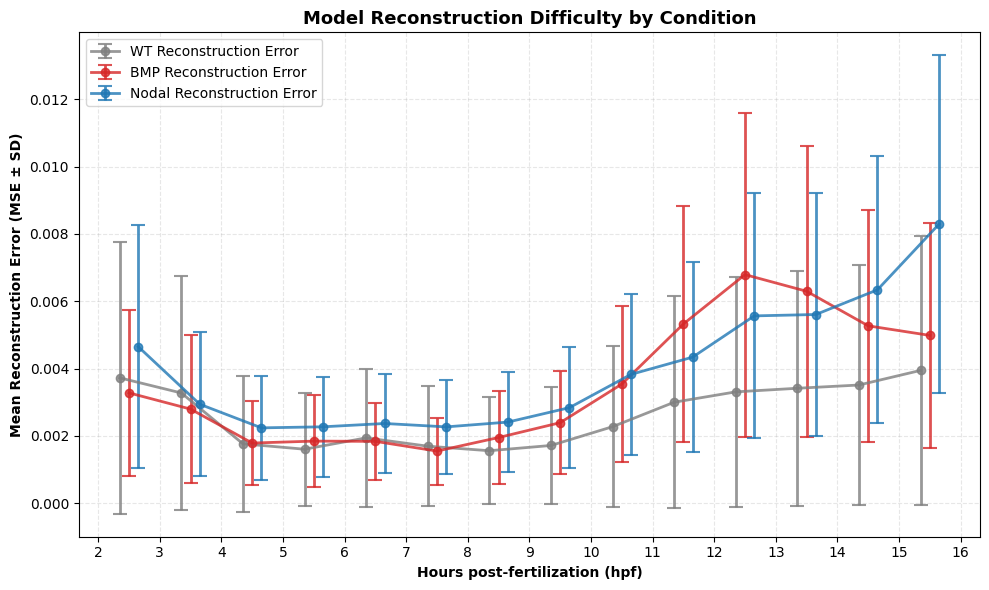

Reconstruction error: /content/drive/MyDrive/DS_ML_MFFF/zfish/recon_error_by_condition_bar.svg


In [24]:
# Configuration
bins = np.arange(2.0, 17.0, 1.0)  # 2–16 hpf
bin_centers = 0.5 * (bins[:-1] + bins[1:])
colors_dict = {"WT": "#7f7f7f", "BMP": "#d62728", "Nodal": "#1f77b4"}
# Small jitter on the X-axis so the error bars don't overlap
offsets = {"WT": -0.15, "BMP": 0.0, "Nodal": 0.15}

plt.figure(figsize=(10, 6))

for cond in ["WT", "BMP", "Nodal"]:
    # Filter data for this condition
    mask_cond = (conditions == cond)
    if not np.any(mask_cond):
        continue

    hpf_cond = hpf_values[mask_cond]
    errors_cond = all_errors[mask_cond] # Using the MSE errors calculated earlier

    means = []
    stds = []

    # Calculate Mean and SD for each 1-hour bin
    for i in range(1, len(bins)):
        bin_mask = (hpf_cond >= bins[i-1]) & (hpf_cond < bins[i])
        if np.any(bin_mask):
            bin_data = errors_cond[bin_mask]
            means.append(bin_data.mean())
            stds.append(bin_data.std())
        else:
            means.append(np.nan)
            stds.append(np.nan)

    #Plotting with Error Bars
    plt.errorbar(
        bin_centers + offsets[cond],
        means,
        yerr=stds,
        label=f"{cond} Reconstruction Error",
        fmt='-o',
        color=colors_dict[cond],
        linewidth=2,
        markersize=6,
        capsize=5,
        capthick=1.5,
        alpha=0.8
    )

#Format
plt.xlabel("Hours post-fertilization (hpf)", fontweight='bold')
plt.ylabel("Mean Reconstruction Error (MSE ± SD)", fontweight='bold')
plt.title("Model Reconstruction Difficulty by Condition", fontsize=13, fontweight='bold')
plt.xticks(np.arange(2, 17, 1))
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=True, facecolor='white', loc='upper left')

plt.tight_layout()

# Export as SVG
out_path_recon_cond = os.path.join(save_path, "recon_error_by_condition_bar.svg")
plt.savefig(out_path_recon_cond, format='svg', bbox_inches="tight")

plt.show()

print(f"Reconstruction error: {out_path_recon_cond}")

In [25]:
hpf_start = 2.0
hpf_end   = 16.0

hpf_values = []

for L in lengths_test:
    if L <= 1:
        times = np.array([(hpf_start + hpf_end)/2])
    else:
        times = np.linspace(hpf_start, hpf_end, L)
    hpf_values.append(times)

hpf_values = np.concatenate(hpf_values)
print("hpf_values length:", len(hpf_values))


hpf_values length: 5400


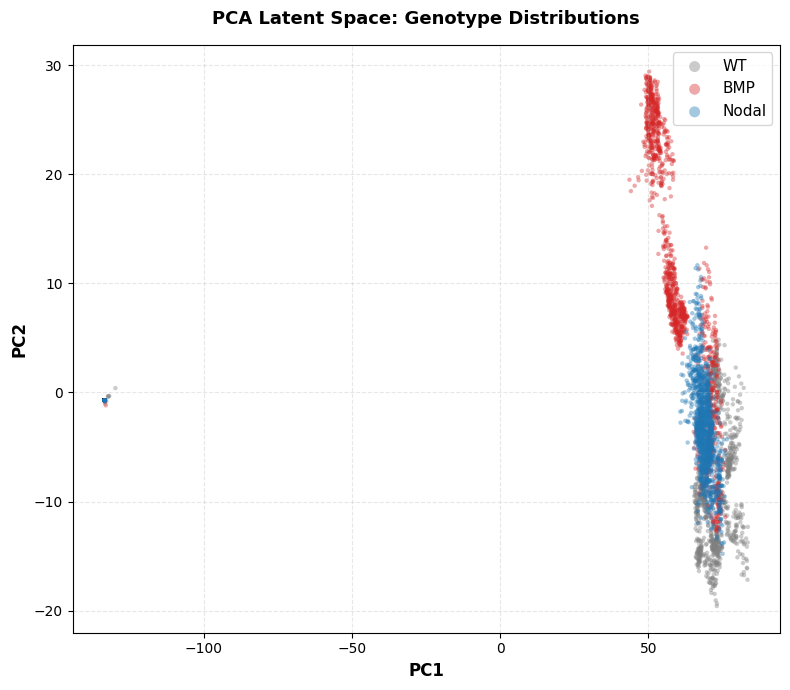

saved: /content/drive/MyDrive/DS_ML_MFFF/zfish/PCA_Latent_Scatter.svg


In [26]:

# Established color palette
colors_dict = {"WT": "#7f7f7f", "BMP": "#d62728", "Nodal": "#1f77b4"}
cond_list = ["WT", "BMP", "Nodal"]

# Create the figure
fig, ax = plt.subplots(figsize=(8, 7))

# PLOT
for cond in cond_list:
    mask = (conditions == cond)
    if not np.any(mask):
        continue

    # Scatter points to show the density and distribution
    ax.scatter(
        Z_test_pca[mask, 0],
        Z_test_pca[mask, 1],
        s=10,
        alpha=0.4,           # Transparency allows seeing density where points overlap
        label=cond,
        color=colors_dict[cond],
        edgecolors='none'
    )

# Styling and Labels
ax.set_xlabel("PC1", fontweight='bold', fontsize=12)
ax.set_ylabel("PC2", fontweight='bold', fontsize=12)
ax.set_title("PCA Latent Space: Genotype Distributions", fontsize=13, fontweight='bold', pad=15)

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(markerscale=2.5, fontsize=11, frameon=True, loc='best')

plt.tight_layout()

# Exportation
out_pca_scatter_svg = os.path.join(save_path, "PCA_Latent_Scatter.svg")
plt.savefig(out_pca_scatter_svg, format='svg', bbox_inches="tight")

plt.show()

print(f"saved: {out_pca_scatter_svg}")

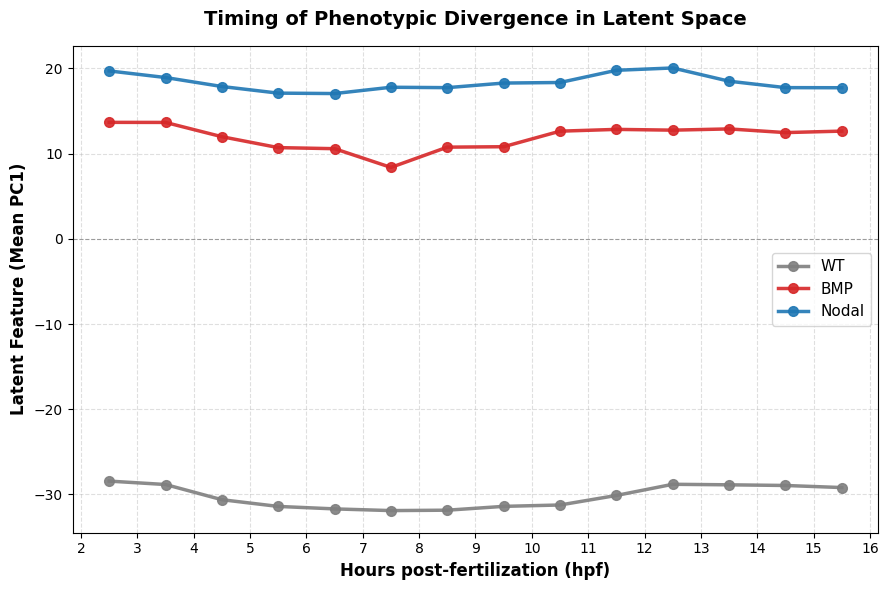

saved: /content/drive/MyDrive/DS_ML_MFFF/zfish/divergence_PC1_vs_hpf_clean_nobar.svg


In [27]:
#Configuration & established colors
bins = np.arange(2.0, 17.0, 1.0)  # 2–16 hpf, 1h bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Consistent color palette
colors_dict = {"WT": "#7f7f7f", "BMP": "#d62728", "Nodal": "#1f77b4"}

plt.figure(figsize=(9, 6))

for cond in cond_list:
    mask_cond = (conditions == cond)
    if not np.any(mask_cond):
        continue

    hpf_cond = hpf_values[mask_cond]
    pc1_cond = Z_test_pca[mask_cond, 0]

    means = []

    # Calculate Mean per 1h bin
    for i in range(1, len(bins)):
        bin_mask = (hpf_cond >= bins[i-1]) & (hpf_cond < bins[i])
        if np.any(bin_mask):
            means.append(pc1_cond[bin_mask].mean())
        else:
            means.append(np.nan)

    means = np.array(means)

    # Line Plot
    plt.plot(
        bin_centers,
        means,
        "-o",                   # Line with circle markers
        label=cond,
        color=colors_dict[cond],
        linewidth=2.5,          # Slightly thicker line for better visibility
        markersize=7,
        alpha=0.9
    )

# Enhanced Labels and Styling
plt.xlabel("Hours post-fertilization (hpf)", fontweight='bold', fontsize=12)
plt.ylabel("Latent Feature (Mean PC1)", fontweight='bold', fontsize=12)
plt.title("Timing of Phenotypic Divergence in Latent Space", fontsize=14, fontweight='bold', pad=15)

# Add horizontal line at 0 for reference
plt.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.3)

plt.xticks(np.arange(2, 17, 1))
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(frameon=True, shadow=False, facecolor='white', loc='best', fontsize=11)

plt.tight_layout()


out_div_svg = os.path.join(save_path, "divergence_PC1_vs_hpf_clean_nobar.svg")
plt.savefig(out_div_svg, format='svg', bbox_inches="tight")

plt.show()

print(f"saved: {out_div_svg}")

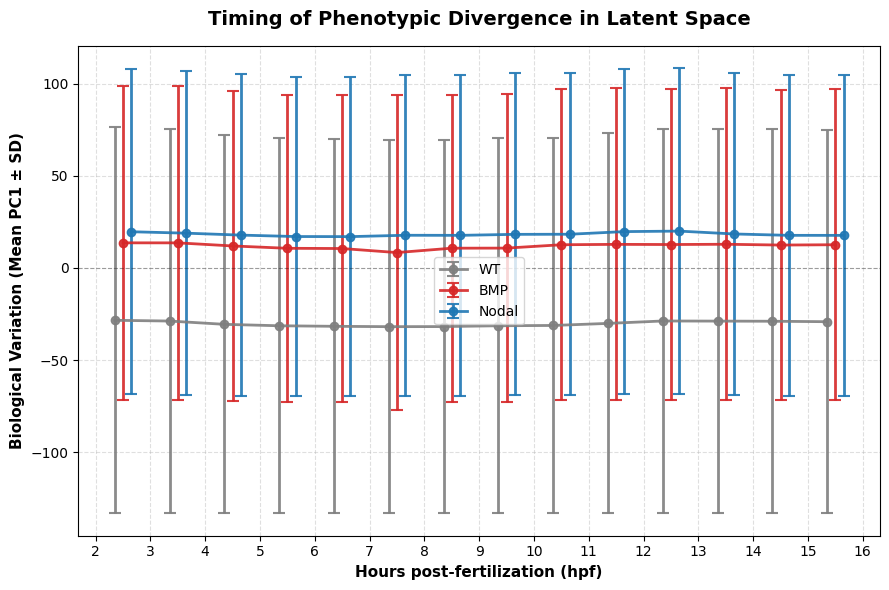

saved: /content/drive/MyDrive/DS_ML_MFFF/zfish/divergence_PC1_vs_hpf_bar.svg


In [28]:
# Configuration & established colors
bins = np.arange(2.0, 17.0, 1.0)  # 2–16 hpf, 1h bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Consistent color palette
colors_dict = {"WT": "#7f7f7f", "BMP": "#d62728", "Nodal": "#1f77b4"}
# Jitter to avoid overlapping error bars
offsets = {"WT": -0.15, "BMP": 0.0, "Nodal": 0.15}

plt.figure(figsize=(9, 6))

for cond in cond_list:
    mask_cond = (conditions == cond)
    if not np.any(mask_cond):
        continue

    hpf_cond = hpf_values[mask_cond]
    pc1_cond = Z_test_pca[mask_cond, 0]

    means = []
    stds = []

    # Calculate stats per 1h bin
    for i in range(1, len(bins)):
        bin_mask = (hpf_cond >= bins[i-1]) & (hpf_cond < bins[i])
        if np.any(bin_mask):
            bin_data = pc1_cond[bin_mask]
            means.append(bin_data.mean())
            stds.append(bin_data.std())
        else:
            means.append(np.nan)
            stds.append(np.nan)

    means = np.array(means)
    stds = np.array(stds)

    # Plotting
    plt.errorbar(
        bin_centers + offsets[cond],
        means,
        yerr=stds,
        label=cond,
        fmt='-o',               # Line with circle markers
        color=colors_dict[cond],
        linewidth=2,
        markersize=6,
        capsize=4,              # Adds the "caps" to the error bars
        capthick=1.5,
        alpha=0.9
    )

# Enhanced Labels and Styling
plt.xlabel("Hours post-fertilization (hpf)", fontweight='bold', fontsize=11)
plt.ylabel("Biological Variation (Mean PC1 ± SD)", fontweight='bold', fontsize=11)
plt.title("Timing of Phenotypic Divergence in Latent Space", fontsize=14, fontweight='bold', pad=15)

plt.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.3)

plt.xticks(np.arange(2, 17, 1))
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(frameon=True, shadow=False, facecolor='white', loc='best', fontsize=10)

plt.tight_layout()

# Exportation
out_div_svg = os.path.join(save_path, "divergence_PC1_vs_hpf_bar.svg")
plt.savefig(out_div_svg, format='svg', bbox_inches="tight")

plt.show()

print(f"saved: {out_div_svg}")

In [29]:
# UMAP to 2D
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)

Z_test_umap = reducer.fit_transform(Z_test_np)  # shape: (N_test, 2)
print("UMAP shape:", Z_test_umap.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (5400, 2)


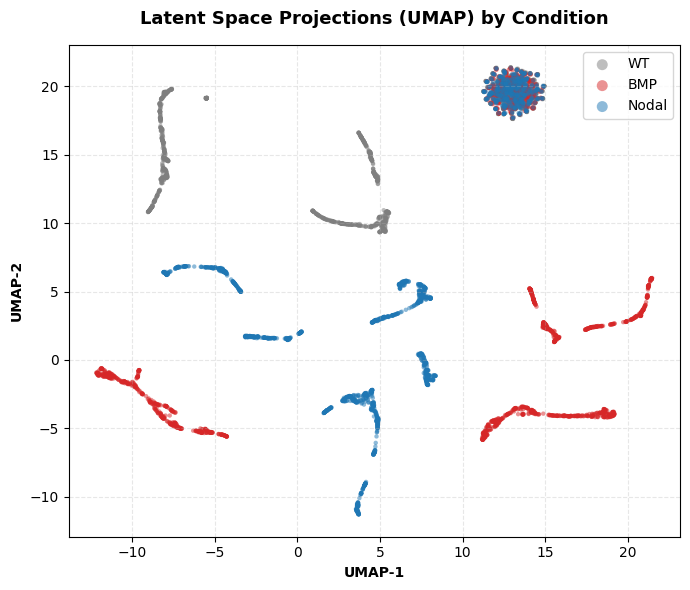

Saved UMAP: /content/drive/MyDrive/DS_ML_MFFF/zfish/latent_UMAP_conditions.svg


In [30]:
# established color palette
colors_dict = {"WT": "#7f7f7f", "BMP": "#d62728", "Nodal": "#1f77b4"}
cond_list = ["WT", "BMP", "Nodal"]

plt.figure(figsize=(7, 6))

for cond in cond_list:
    mask = (conditions == cond)
    if not np.any(mask):
        continue

    plt.scatter(
        Z_test_umap[mask, 0],
        Z_test_umap[mask, 1],
        s=10,                # Slightly larger for better visibility
        alpha=0.5,           # Transparency to see cluster density
        label=cond,
        color=colors_dict[cond],
        edgecolors='none'
    )

# Enhanced Styling
plt.xlabel("UMAP-1", fontweight='bold')
plt.ylabel("UMAP-2", fontweight='bold')
plt.title("Latent Space Projections (UMAP) by Condition", fontsize=13, fontweight='bold', pad=15)

# Legend with larger markers for clarity
plt.legend(markerscale=2.5, frameon=True, facecolor='white', loc='best')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

out_umap_svg = os.path.join(save_path, "latent_UMAP_conditions.svg")
plt.savefig(out_umap_svg, format='svg', bbox_inches="tight")

plt.show()

print(f"Saved UMAP: {out_umap_svg}")

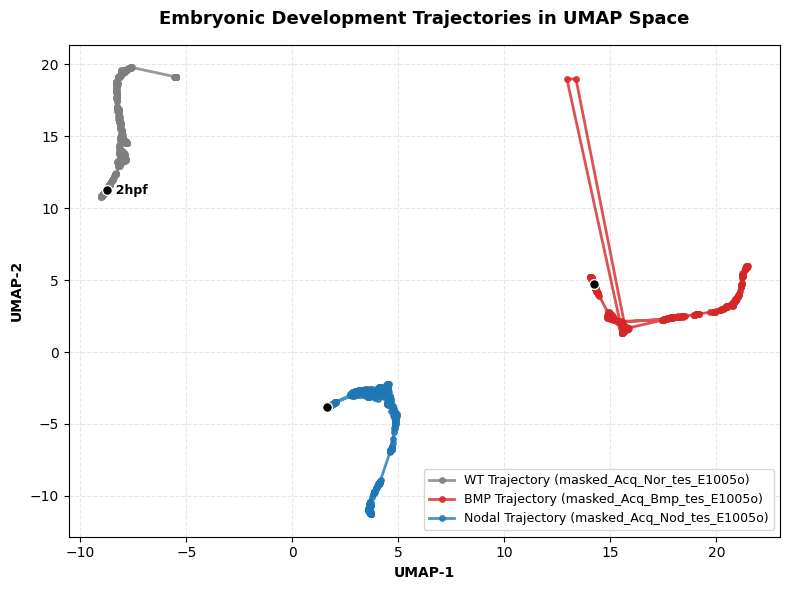

Saved UMAP: /content/drive/MyDrive/DS_ML_MFFF/zfish/latent_UMAP_trajectories.svg


In [31]:
# Configuration and established colors
colors_dict = {"WT": "#7f7f7f", "BMP": "#d62728", "Nodal": "#1f77b4"}
cond_list = ["WT", "BMP", "Nodal"]

plt.figure(figsize=(8, 6))

for cond in cond_list:
    # Get unique embryo IDs for this condition
    ids_cond = np.unique(embryo_ids_test[conditions == cond])
    if len(ids_cond) == 0:
        continue

    # Take the first embryo of this condition as the representative example
    eid = ids_cond[0]
    mask = (embryo_ids_test == eid)

    # Order frames by time (frame_idx)
    frame_idx = dfmeta_test["frame_idx"].values[mask]
    order = np.argsort(frame_idx)
    traj = Z_test_umap[mask][order]

    # Plotting the trajectory
    plt.plot(
        traj[:, 0], traj[:, 1],
        "-o",
        color=colors_dict[cond],
        linewidth=2,
        markersize=4,
        alpha=0.8,
        label=f"{cond} Trajectory ({eid})"
    )

    # Mark the START (2hpf) of the trajectory
    plt.scatter(traj[0, 0], traj[0, 1], color='black', s=50, edgecolors='white', zorder=5)
    if cond == "WT": # Just add one text label for Start
        plt.text(traj[0, 0], traj[0, 1], "  2hpf", verticalalignment='center', fontsize=9, fontweight='bold')

# Enhanced Styling
plt.xlabel("UMAP-1", fontweight='bold')
plt.ylabel("UMAP-2", fontweight='bold')
plt.title("Embryonic Development Trajectories in UMAP Space", fontsize=13, fontweight='bold', pad=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=9, frameon=True, facecolor='white', loc='best')

plt.tight_layout()

# Standardized Exportation
out_umap_traj_svg = os.path.join(save_path, "latent_UMAP_trajectories.svg")
plt.savefig(out_umap_traj_svg, format='svg', bbox_inches="tight")

plt.show()

print(f"Saved UMAP: {out_umap_traj_svg}")